In [ ]:
# Install Transformers
!pip install transformers
# To get model summary
!pip install torch

In [ ]:
!pip install seaborn

In [ ]:
#import required package
import numpy as np
import pandas as pd
import seaborn as sns
import re
import torch
import random
import torch.nn as nn
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
import pickle
from tqdm import tqdm
import gradio as gr

2023-08-14 03:17:51.971632: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-14 03:17:52.770602: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# specify GPU
device = torch.device("cuda")

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [ ]:
#read the reviews of fine food from .csv file
reviews_df=pd.read_csv("/home/divya/vivek5/amazon question answer/Reviews.csv")

In [ ]:
#view starting 5 sample from dataset
reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
def itemfreq(data):
    """
    Calculate the frequency of unique items in a 1D array.

    This function takes a 1D array and calculates the frequency of each unique item
    present in the array. It returns two arrays: one containing the unique items and
    another containing the corresponding frequencies of those items.

    Parameters
    ----------
    data : array_like
        The input 1D array for which item frequencies will be calculated.

    Returns
    -------
    items : ndarray
        1D array
            The unique items present in the input data.

    freq : ndarray
        1D array
            The frequencies of the corresponding unique items. The frequency at
            index 'i' in this array corresponds to the item at index 'i' in the 'items' array.
    """
    items, inv = np.unique(data, return_inverse=True)
    freq = np.bincount(inv)
    return items, freq


(array([ 18296.,      0.,  10575.,      0.,      0.,  15624.,      0.,
         29118.,      0., 126387.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

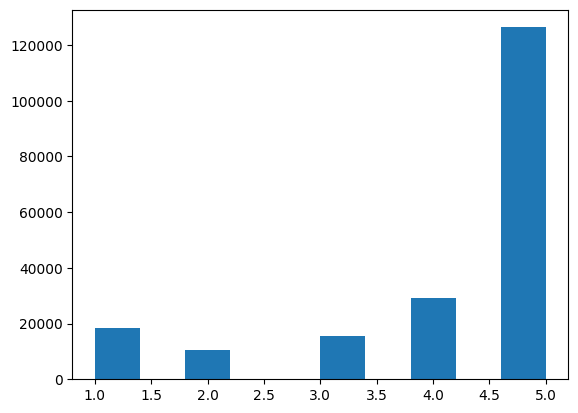

In [ ]:
#plot of number of times occurs particular rating
plt.hist(reviews_df.Score)

***Determine sentiment based on a numerical score.***

In [ ]:

def get_sentiment(score):
    """
    Determine sentiment based on a numerical score.

    This function takes a numerical score as input and assigns a sentiment label
    based on predefined thresholds. Scores less than or equal to 2 are considered
    as having a negative sentiment, scores equal to 3 are considered neutral,
    and scores greater than 3 are considered positive.

    Parameters
    ----------
    score : int or float
        The numerical score for which sentiment needs to be determined.

    Returns
    -------
    sentiment : int
        An integer representing the sentiment:
        - 0: Negative sentiment
        - 1: Neutral sentiment
        - 2: Positive sentiment
    """

    if score <= 2:
        return 0  # Negative sentiment
    elif score == 3:
        return 1  # Neutral sentiment
    else:
        return 2  # Positive sentiment

# Applying the get_sentiment function to a DataFrame column
reviews_df['sentiment'] = reviews_df.Score.apply(get_sentiment)

# Displaying the first 2 rows of the DataFrame
reviews_df.head(2)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0


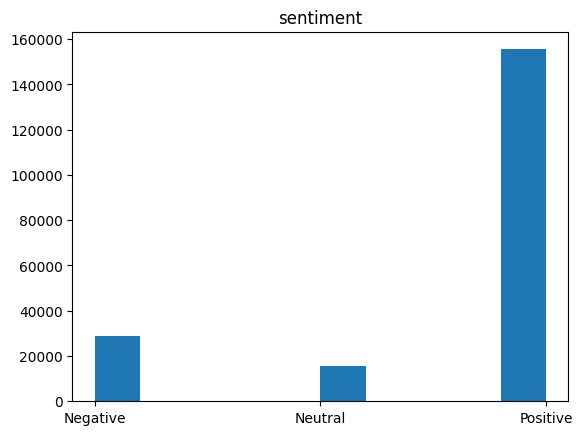

In [ ]:
#histogram of number of times occurs particular sentiment in dataframe
plt.figure()
plt.hist(reviews_df['sentiment'])
plt.xticks([0, 1, 2],['Negative','Neutral','Positive'])
plt.title('sentiment')
plt.show()

In [ ]:
# Define the pre-trained model name
MODEL_NAME = 'bert-base-cased'

# Load the tokenizer for the specified model
tokenizer = transformers.BertTokenizer.from_pretrained(MODEL_NAME)

# Sample text for tokenization
sample_text = "originally gave this a 2 star"

# Tokenize the sample text
tokens = tokenizer.tokenize(sample_text)

# Convert tokens to their corresponding IDs
ids = tokenizer.convert_tokens_to_ids(tokens)

# Print original text, tokens, and token IDs
print(f'Original Text: {sample_text}')
print('='*60)
print('Tokens:', tokens)
print('='*60)
print('Token IDs:', ids)


originally gave this a 2 star
['originally', 'gave', 'this', 'a', '2', 'star']
[2034, 1522, 1142, 170, 123, 2851]


This code prints the special tokens and their corresponding token IDs using the BERT tokenizer from the transformers library. It provides information about the SEP (separator) token and its ID, the CLS (classification) token and its ID, the UNK (unknown) token and its ID, and the PAD (padding) token and its ID. Each line of code prints the token's name and its associated ID for clarity.

In [ ]:
print(tokenizer.sep_token , tokenizer.sep_token_id)
print(tokenizer.cls_token,tokenizer.cls_token_id)
print(tokenizer.unk_token,tokenizer.unk_token_id)
print(tokenizer.pad_token,tokenizer.pad_token_id)

[SEP] 102
[CLS] 101
[UNK] 100
[PAD] 0


In [ ]:
# Store length of each review
token_lens = []

# Iterate through the content slide
for txt in reviews_df['Text']:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/tmp/ipykernel_2118880/3831590266.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


Text(0.5, 0, 'Token count')

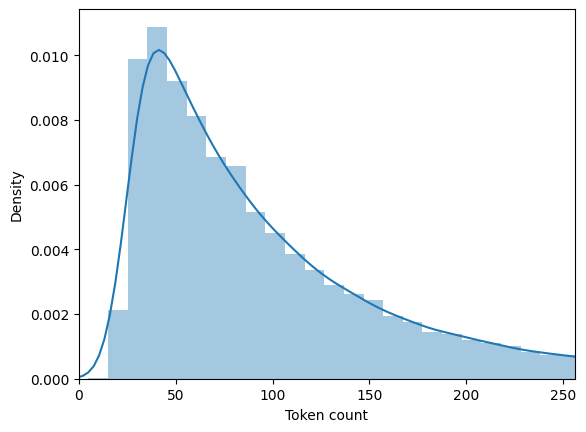

In [ ]:
# plot the distribution of review lengths
sns.distplot(token_lens)
plt.xlim([0, 256])
plt.xlabel('Token count')

In [ ]:
MAX_LEN = 250

In [ ]:
class GPReviewDataset(Dataset):
    """
    Custom PyTorch dataset for sentiment analysis of reviews using BERT-based models.

    This dataset class is designed to work with reviews and corresponding sentiment labels. It prepares
    the data for model input by tokenizing the reviews, encoding them with special tokens, and padding
    sequences to a specified maximum length.

    Parameters:
    -----------
    reviews : list or array-like
        List of review texts.

    targets : list or array-like
        List of sentiment labels corresponding to the reviews.

    tokenizer : transformers.PreTrainedTokenizer
        A tokenizer object from the transformers library for tokenizing the review texts.

    max_len : int
        The maximum length of the tokenized and padded sequences.

    Returns:
    --------
    dict
        A dictionary containing the following items:
        - 'review_text': The original review text.
        - 'input_ids': Tensor of token IDs after tokenization and padding.
        - 'attention_mask': Tensor indicating positions of valid tokens.
        - 'targets': Tensor containing the sentiment label for the review.
    """

    def __init__(self, reviews, targets, tokenizer, max_len):
        """
        Initialize the dataset with reviews, sentiment labels, tokenizer, and maximum sequence length.
        """
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        """
        Get the total number of samples in the dataset.
        """
        return len(self.reviews)

    def __getitem__(self, item):
        """
        Get a single sample from the dataset by its index.

        Parameters:
        -----------
        item : int
            Index of the sample to retrieve.

        Returns:
        --------
        dict
            A dictionary containing the prepared data for the model.
        """
        review = str(self.reviews[item])
        target = self.targets[item]

        # Encode the review text using the tokenizer
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
# Split the original dataset into training, validation, and test sets
df_train, df_test = train_test_split(reviews_df, test_size=0.2, random_state=46)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=46)

# Print the shapes of the resulting datasets
print(df_train.shape, df_val.shape, df_test.shape)

(160000, 11) (20000, 11) (20000, 11)


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    """
    Create a PyTorch DataLoader for sentiment analysis dataset.

    This function takes a DataFrame, tokenizer, maximum sequence length, and batch size as input and
    returns a DataLoader that provides batches of preprocessed data for sentiment analysis using BERT-based models.

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing 'Text' and 'sentiment' columns.

    tokenizer : transformers.PreTrainedTokenizer
        A tokenizer object from the transformers library for tokenizing the review texts.

    max_len : int
        The maximum length of the tokenized and padded sequences.

    batch_size : int
        The desired batch size for the DataLoader.

    Returns:
    --------
    torch.utils.data.DataLoader
        A DataLoader instance that provides batches of preprocessed data for sentiment analysis.

    Example:
    --------
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')
    train_loader = create_data_loader(df_train, tokenizer, max_len=128, batch_size=32)
    """

    ds = GPReviewDataset(
        reviews=df.Text.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [ ]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Examples
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 250])
torch.Size([16, 250])
torch.Size([16])


/home/divya/.venv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


*** Load the basic BERT model ***

In [ ]:
bert_model = BertModel.from_pretrained(MODEL_NAME)

In [ ]:
import torch.nn as nn
from transformers import BertModel

class SentimentClassifier(nn.Module):
    """
    Sentiment classification model based on BERT.

    This class defines a sentiment classification model using BERT as the base. The BERT model is followed
    by a dropout layer and a linear layer for predicting sentiment classes.

    Parameters:
    -----------
    n_classes : int
        Number of sentiment classes for classification.

    Methods:
    --------
    forward(input_ids, attention_mask)
        Forward pass through the model for prediction.
    """

    def __init__(self, n_classes):
        """
        Initialize the sentiment classifier model.

        Parameters:
        -----------
        n_classes : int
            Number of sentiment classes for classification.
        """
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        """
        Perform a forward pass through the model for prediction.

        Parameters:
        -----------
        input_ids : torch.Tensor
            Tensor containing the token IDs of the input text.

        attention_mask : torch.Tensor
            Tensor containing the attention mask for the input text.

        Returns:
        --------
        torch.Tensor
            The model's predicted output.
        """
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(output.pooler_output)
        return self.out(output)

In [ ]:
class_names = ['negative', 'neutral', 'positive']
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


In [ ]:
# Number of training iterations
EPOCHS = 10

# Create an Adam optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

# Calculate the total training steps
total_steps = len(train_data_loader) * EPOCHS

# Create a learning rate scheduler with warm-up
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

/home/divya/.venv/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    """
    Perform a single training epoch.

    This function trains the model for one epoch using the provided data loader, loss function, optimizer,
    and scheduler.

    Parameters:
    -----------
    model : nn.Module
        The sentiment classification model to be trained.

    data_loader : torch.utils.data.DataLoader
        The data loader providing training data.

    loss_fn : nn.Module
        The loss function to calculate the training loss.

    optimizer : torch.optim.Optimizer
        The optimizer for updating the model's parameters.

    device : torch.device
        The device (CPU or GPU) on which the training is performed.

    scheduler : torch.optim.lr_scheduler
        The learning rate scheduler for adjusting the learning rate during training.

    n_examples : int
        The total number of training examples.

    Returns:
    --------
    float, float
        The accuracy and average loss for the epoch.
    """

    model = model.train()
    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward propagation
        loss.backward()
        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    """
    Evaluate the model's performance on the validation or test dataset.

    This function evaluates the model's performance on the provided dataset using the provided data loader,
    loss function, and device.

    Parameters:
    -----------
    model : nn.Module
        The sentiment classification model to be evaluated.

    data_loader : torch.utils.data.DataLoader
        The data loader providing validation or test data.

    loss_fn : nn.Module
        The loss function to calculate the evaluation loss.

    device : torch.device
        The device (CPU or GPU) on which the evaluation is performed.

    n_examples : int
        The total number of examples in the dataset.

    Returns:
    --------
    float, float
        The accuracy and average loss for the evaluation.
    """

    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model outputs
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

*** Training the model ***

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show epoch details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    # Train the model for one epoch
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f"Train loss {train_loss:.4f} accuracy {train_acc:.4f}")

    # Evaluate the model on the validation set
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f"Val   loss {val_loss:.4f} accuracy {val_acc:.4f}")
    print()

    # Save history of training and validation metrics
    history['train_acc'].append(train_acc.item())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.item())
    history['val_loss'].append(val_loss)

    # Save model checkpoint if validation accuracy improves
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

    # Save model and SentimentClassifier class using pickle
    dict_ = {'model': model, 'SentimentClassifier': SentimentClassifier}
    with open('/home/divya/vivek5/sentiment_analysis_finetune_bert.pkl', 'wb') as f:
        pickle.dump(dict_, f)

Epoch 1/10
----------


100%|██████████| 10000/10000 [48:27<00:00,  3.44it/s]


Train loss 0.437259683095105 accuracy 0.8518
Val   loss 0.395620401853323 accuracy 0.88105

Epoch 2/10
----------


100%|██████████| 10000/10000 [48:42<00:00,  3.42it/s]


Train loss 0.3355792592415586 accuracy 0.888475
Val   loss 0.3036631541714072 accuracy 0.89575

Epoch 3/10
----------


100%|██████████| 10000/10000 [48:32<00:00,  3.43it/s]


Train loss 0.28131443123938515 accuracy 0.90975625
Val   loss 0.32476626813784243 accuracy 0.9003

Epoch 4/10
----------


100%|██████████| 10000/10000 [48:35<00:00,  3.43it/s]


Train loss 0.2513500333808362 accuracy 0.9251312500000001
Val   loss 0.32960303543359043 accuracy 0.8998

Epoch 5/10
----------


100%|██████████| 10000/10000 [48:40<00:00,  3.42it/s]


Train loss 0.22257677220288896 accuracy 0.9372812500000001
Val   loss 0.344810073299706 accuracy 0.9042

Epoch 6/10
----------


100%|██████████| 10000/10000 [48:36<00:00,  3.43it/s]


Train loss 0.19210175439191515 accuracy 0.948725
Val   loss 0.3947672142362222 accuracy 0.904

Epoch 7/10
----------


100%|██████████| 10000/10000 [48:40<00:00,  3.42it/s]


Train loss 0.16836651281533996 accuracy 0.95810625
Val   loss 0.4523221901897341 accuracy 0.9039

Epoch 8/10
----------


100%|██████████| 10000/10000 [48:36<00:00,  3.43it/s]


Train loss 0.14673091283872491 accuracy 0.9650937500000001
Val   loss 0.4342103717836551 accuracy 0.9106000000000001

Epoch 9/10
----------


100%|██████████| 10000/10000 [48:42<00:00,  3.42it/s]


Train loss 0.12769193379548377 accuracy 0.9709000000000001
Val   loss 0.4672267551389523 accuracy 0.9105000000000001

Epoch 10/10
----------


100%|██████████| 10000/10000 [49:31<00:00,  3.37it/s]


Train loss 0.11631839626120637 accuracy 0.9739625000000001
Val   loss 0.46442474859515204 accuracy 0.9126500000000001



(0.0, 1.0)

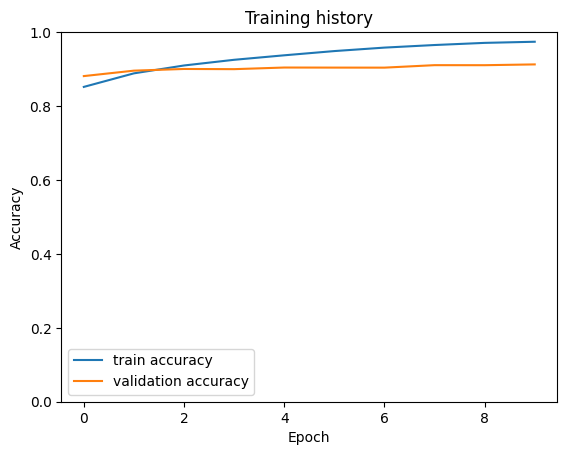

In [ ]:
# Plot training and validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9063

In [ ]:
def get_predictions(model, data_loader):
    """
    Generate predictions and evaluation metrics using a trained sentiment classification model.

    This function takes a trained sentiment classification model and a data loader providing input data
    for evaluation. It returns lists containing review texts, predicted sentiment labels, prediction
    probabilities, and actual sentiment labels.

    Parameters:
    -----------
    model : nn.Module
        The trained sentiment classification model.

    data_loader : torch.utils.data.DataLoader
        The data loader providing input data for evaluation.

    Returns:
    --------
    list, list, list, list
        Lists containing review texts, predicted sentiment labels, prediction probabilities, and actual
        sentiment labels, respectively.
    """

    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds.tolist())
            prediction_probs.extend(outputs.tolist())
            real_values.extend(targets.tolist())

    return review_texts, predictions, prediction_probs, real_values

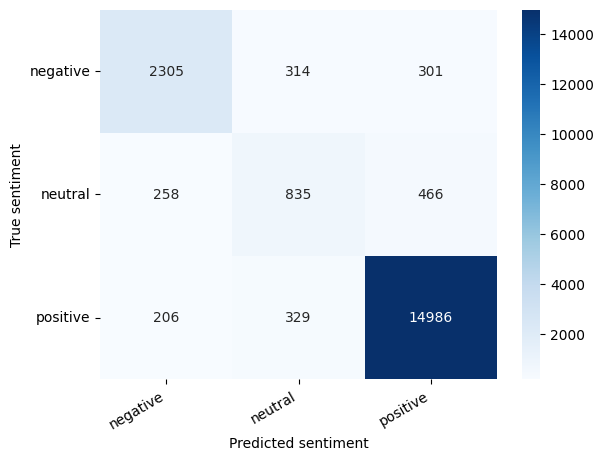

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def show_confusion_matrix(confusion_matrix):
    """
    Display a confusion matrix using a heatmap.

    This function takes a confusion matrix as input and displays it using a heatmap with labeled axes.

    Parameters:
    -----------
    confusion_matrix : numpy.ndarray
        The confusion matrix to be visualized
    """

    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

#Example

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

In [ ]:
def softmax(array_):
    return np.exp(array_)/ np.sum(np.exp(array_))

In [ ]:
def sentiment_analyse(review_text):
    encoded_review = tokenizer.encode_plus(
        review_text,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    return "given review is "+str(class_names[prediction])+" with " +str(round(np.max(softmax(output.detach().cpu().numpy()))*100,2))+"% confidence"

In [ ]:
sentiment_analyse(review_text)

'given review is positive with 96.9% confidence'